# An analysis of sex ratios using a biodiversity data cube

This notebook was created for analysing GBIF download https://www.gbif.org/occurrence/download/0083528-240321170329656
Date 2 April 2024
Occurrences 4,038,527
Involved datasets 4,985
Involved publishers 230

Note: This select ignores ```dwc:individualCount``` in the record. It treats each record as an individual.
In the future it

``` SELECT "year", gbif_eeargCode(10000, decimalLatitude, decimalLongitude, COALESCE(coordinateUncertaintyInMeters, 10000)) AS eeaCellCode, speciesKey, COUNT(*) AS 'count', SUM(CASE WHEN sex = 'FEMALE' THEN 1 ELSE 0 END) AS female_count, SUM(CASE WHEN sex = 'MALE' THEN 1 ELSE 0 END) AS male_count, SUM(CASE WHEN sex = 'HERMERMAPHRODITE' THEN 1 ELSE 0 END) AS hermaphrodite_count, MIN(COALESCE(coordinateUncertaintyInMeters, 10000)) AS minCoordinateUncertaintyInMeters FROM occurrence WHERE occurrenceStatus = 'PRESENT' AND familyKey = 2986 AND NOT array_contains(issue, 'ZERO_COORDINATE') AND NOT array_contains(issue, 'COORDINATE_OUT_OF_RANGE') AND NOT array_contains(issue, 'COORDINATE_INVALID') AND NOT array_contains(issue, 'COUNTRY_COORDINATE_MISMATCH') AND (identificationVerificationStatus IS NULL OR NOT ( LOWER(identificationVerificationStatus) LIKE '%unverified%' OR LOWER(identificationVerificationStatus) LIKE '%unvalidated%' OR LOWER(identificationVerificationStatus) LIKE '%not able to validate%' OR LOWER(identificationVerificationStatus) LIKE '%control could not be conclusive due to insufficient knowledge%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed%' OR LOWER(identificationVerificationStatus) LIKE '%unconfirmed - not reviewed%' OR LOWER(identificationVerificationStatus) LIKE '%validation requested%' ) ) AND "year" >= 1900 AND continent = 'EUROPE' AND hasCoordinate GROUP BY "year", eeaCellCode, speciesKey ORDER BY "year" DESC, eeaCellCode ASC, speciesKey ASC; ```

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import seaborn as sns
from shapely.geometry import Polygon

In [2]:
# Read the file, assuming it's tab-separated and the first row contains column names
file_path = '0083528-240321170329656.csv'   
df = pd.read_csv(file_path, sep='\t')

In [3]:
#Splits the 'eeacellcode' column into three new columns ('resolution', 'long', 'lat')
#    with four characters in each and adds them to the DataFrame.
#
#    Parameters:
#    - df: The original DataFrame containing the 'eeacellcode' column.
#
#    Returns:
#    - df: The modified DataFrame with the new columns added.
#    """
# Check if 'eeacellcode' column exists in the DataFrame
if 'eeacellcode' in df.columns:
     # Splitting the 'eeacellcode' column into three new columns
     df['resolution'] = df['eeacellcode'].str[:4]
     df['long'] = df['eeacellcode'].str[4:8]
     df['lat'] = df['eeacellcode'].str[8:12]
else:
     print("The column 'eeacellcode' does not exist in the DataFrame.")

In [4]:
df = df.dropna()

In [5]:
# Remove the first character from 'long' and 'lat' columns and create new 'longitude' and 'latitude' columns
df['longitude'] = df['long'].str[1:]

In [6]:
df['latitude'] = df['lat'].str[1:]

In [7]:
df['longitude'] = pd.to_numeric(df['longitude'], downcast='float') * 10000
df['latitude'] = pd.to_numeric(df['latitude'], downcast='float') * 10000

In [8]:
# Print the first few rows of the DataFrame to verify the new columns
print(df.head(10))

    year   eeacellcode  specieskey  count  female_count  male_count  \
25  2024  10kmE263N192   8332393.0      1             0           0   
26  2024  10kmE263N195   9751099.0      1             0           0   
27  2024  10kmE264N191   8332393.0      1             0           0   
28  2024  10kmE264N191   9362027.0      1             0           0   
29  2024  10kmE264N192   9362027.0      1             0           0   
30  2024  10kmE264N194   8332393.0      1             0           0   
31  2024  10kmE264N194   9761484.0      1             0           0   
32  2024  10kmE264N195   2498252.0      1             0           0   
33  2024  10kmE264N195   2498343.0      1             0           0   
34  2024  10kmE264N195   9751099.0      1             0           0   

    hermaphrodite_count  mincoordinateuncertaintyinmeters resolution  long  \
25                    0                           28240.0       10km  E263   
26                    0                           10000.0     

In [9]:
# Convert 'longitude' and 'latitude' to numeric types, if they're not already
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')

# Create a new GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system (CRS) to ETRS89-LAEA Europe (EPSG:3035) for latitude and longitude
gdf.crs = "EPSG:3035"

# Now 'gdf' is a GeoDataFrame with a 'geometry' column holding spatial data

# Example: Save this GeoDataFrame to a shapefile
# gdf.to_file("species_locations.shp")

print(gdf.head())


    year   eeacellcode  specieskey  count  female_count  male_count  \
25  2024  10kmE263N192   8332393.0      1             0           0   
26  2024  10kmE263N195   9751099.0      1             0           0   
27  2024  10kmE264N191   8332393.0      1             0           0   
28  2024  10kmE264N191   9362027.0      1             0           0   
29  2024  10kmE264N192   9362027.0      1             0           0   

    hermaphrodite_count  mincoordinateuncertaintyinmeters resolution  long  \
25                    0                           28240.0       10km  E263   
26                    0                           10000.0       10km  E263   
27                    0                           28240.0       10km  E264   
28                    0                           28240.0       10km  E264   
29                    0                           28240.0       10km  E264   

     lat  longitude   latitude                         geometry  
25  N192  2630000.0  1920000.0  POINT 

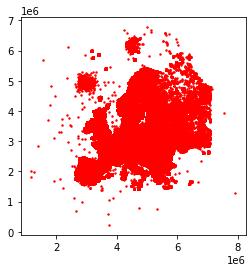

In [10]:
# Basic plot
gdf.plot(marker='o', color='red', markersize=2)
plt.show()


In [11]:
# Step 1: Calculate the start year of the decade for each row and create a new 'decade' column
gdf['decade'] = (gdf['year'] // 10) * 10

In [12]:
gdf['geometry_wkt'] = gdf['geometry'].apply(lambda x: x.wkt)

In [13]:
# Grouping the DataFrame by 'eeacellcode' and 'specieskey'
grouped_df = gdf.groupby(['decade','eeacellcode', 'specieskey', 'long', 'lat', 'longitude', 'latitude','geometry_wkt'])['count', 'female_count', 'male_count'].sum().reset_index()


C:\Users\quentin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
#print(grouped_df.head(1))
print(grouped_df.describe())

             decade    specieskey     longitude      latitude         count  \
count  1.476502e+06  1.476502e+06  1.476502e+06  1.476502e+06  1.476502e+06   
mean   2.003892e+03  4.942655e+06  4.240123e+06  3.424666e+06  2.421870e+01   
std    1.680429e+01  3.071132e+06  7.506423e+05  8.232751e+05  1.345226e+02   
min    1.900000e+03  2.497999e+06  1.160000e+06  2.300000e+05  1.000000e+00   
25%    2.000000e+03  2.498255e+06  3.630000e+06  2.860000e+06  1.000000e+00   
50%    2.010000e+03  2.498347e+06  4.260000e+06  3.370000e+06  2.000000e+00   
75%    2.020000e+03  8.214667e+06  4.730000e+06  4.010000e+06  8.000000e+00   
max    2.020000e+03  1.225812e+07  7.930000e+06  6.770000e+06  1.719800e+04   

       female_count    male_count  
count  1.476502e+06  1.476502e+06  
mean   5.334270e-01  7.615987e-01  
std    1.402021e+01  1.186829e+01  
min    0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  


In [15]:
print(grouped_df.crs)

EPSG:3035


In [16]:
print(grouped_df.columns)

Index(['decade', 'eeacellcode', 'specieskey', 'long', 'lat', 'longitude',
       'latitude', 'geometry_wkt', 'count', 'female_count', 'male_count'],
      dtype='object')


In [17]:
grouped_df['geometry'] = grouped_df['geometry_wkt'].apply(wkt.loads)

In [84]:
duckkey = input("Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): ")

# Check if the input is empty
if not duckkey.strip():
    # Set default value if input is empty
    duckkey = 9761484
    
duckkey = int(duckkey)

print(f"Your duck key is , {duckkey}!")



Enter the taxon key of a European duck from GBIF (default: Anas platyrhynchos = 9761484): 2498352
Your duck key is , 2498352!


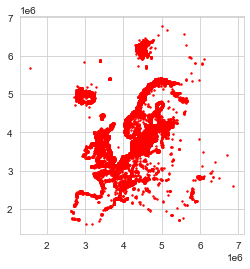

In [85]:
# Basic plot of Aythya fuligula (L., 1758) = 2498261
# Basic plot of Anas platyrhynchos Linnaeus, 1758 = 9761484

# Select rows where the 'specieskey' column matches the specific_specieskey
filtered_gdf = grouped_df[grouped_df['specieskey'] == duckkey]


filtered_gdf.plot(marker='o', color='red', markersize=2)
plt.show()

In [86]:
# Remove rows where both 'female_count' and 'male_count' are zero, and 'eeacellcode' is NaN
filtered_gdf = filtered_gdf[(filtered_gdf['female_count'] > 1) | (filtered_gdf['male_count'] > 1)]

In [87]:
# Ensure there's no division by zero
filtered_gdf['male_to_female_ratio'] = np.where(filtered_gdf['female_count'] > 0, filtered_gdf['male_count'] / (filtered_gdf['female_count'] + filtered_gdf['male_count']), np.nan)


C:\Users\quentin\Anaconda3\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [88]:
# Print the resulting DataFrame to verify the rows have been removed
print(filtered_gdf.head(5))

     decade   eeacellcode  specieskey  long   lat  longitude   latitude  \
717    1900  10kmE388N317   2498352.0  E388  N317  3880000.0  3170000.0   
723    1900  10kmE388N318   2498352.0  E388  N318  3880000.0  3180000.0   
750    1900  10kmE391N314   2498352.0  E391  N314  3910000.0  3140000.0   
902    1900  10kmE396N332   2498352.0  E396  N332  3960000.0  3320000.0   
912    1900  10kmE396N333   2498352.0  E396  N333  3960000.0  3330000.0   

                geometry_wkt  count  female_count  male_count  \
717  POINT (3880000 3170000)      3             3           0   
723  POINT (3880000 3180000)      3             2           1   
750  POINT (3910000 3140000)      2             0           2   
902  POINT (3960000 3320000)      3             1           2   
912  POINT (3960000 3330000)      3             0           3   

                            geometry  male_to_female_ratio  
717  POINT (3880000.000 3170000.000)              0.000000  
723  POINT (3880000.000 3180000.000)

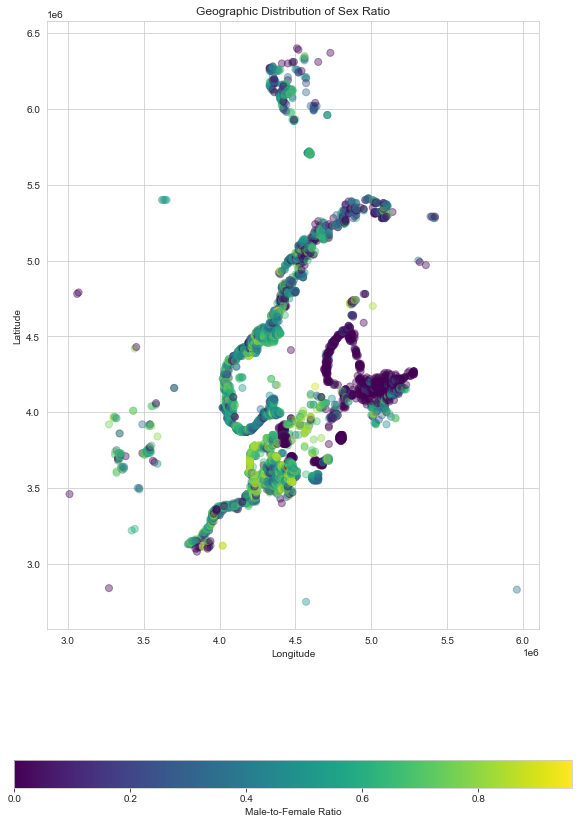

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(10, 16))

# Plot using the 'sex_ratio' column to color the points
filtered_gdf.plot(column='male_to_female_ratio', ax=ax, legend=True, 
         legend_kwds={'label': "Male-to-Female Ratio", 'orientation': "horizontal"},
         cmap='viridis', markersize=50, alpha=0.4)  # Adjust 'markersize' and 'alpha' as needed

plt.title('Geographic Distribution of Sex Ratio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [90]:
# Drop NaN values from your dataset
filtered_gdf = filtered_gdf.dropna(subset=['decade', 'male_to_female_ratio'])

# Also, ensure there are no infinite values
filtered_gdf = filtered_gdf.replace([np.inf, -np.inf], np.nan).dropna(subset=['decade', 'male_to_female_ratio'])

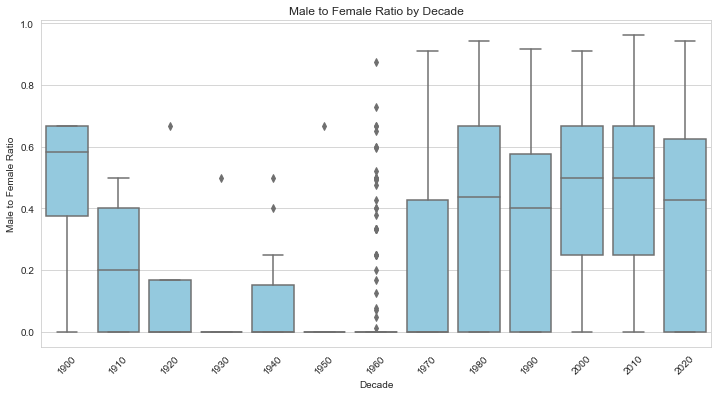

In [91]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

# Create a box plot
sns.boxplot(x='decade', y='male_to_female_ratio', data=filtered_gdf, color='skyblue')

plt.title('Male to Female Ratio by Decade')
plt.xlabel('Decade')
plt.ylabel('Male to Female Ratio')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.savefig('ratiotimeseries.jpg', dpi=600, format='jpg')
plt.show()


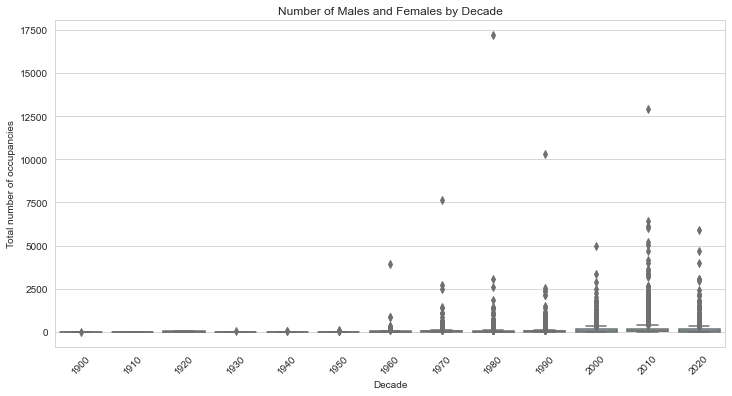

In [92]:
# Setting the aesthetic style of the plots
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))

# Set the y-axis to log scale
ax.set_yscale('log')

# Create a box plot
sns.boxplot(x='decade', y='count', data=filtered_gdf, color='skyblue')

plt.title('Number of Males and Females by Decade')
plt.xlabel('Decade')
plt.ylabel('Total number of occupancies')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()


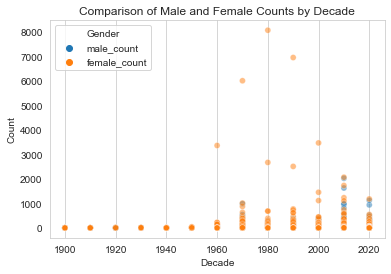

In [93]:
# Assuming gdf is your GeoDataFrame
# Convert GeoDataFrame to a regular DataFrame for the melting process
df = pd.DataFrame(gdf.drop(columns='geometry'))

# Melting the DataFrame
df_melted = filtered_gdf.melt(id_vars=['decade'], value_vars=['male_count', 'female_count'],
                    var_name='Gender', value_name='Count')

# Creating the boxplot with seaborn
sns.scatterplot(x='decade', y='Count', hue='Gender', alpha=0.5, data=df_melted)

plt.title('Comparison of Male and Female Counts by Decade')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.grid(axis='y')

plt.savefig('count.jpg', dpi=600, format='jpg')

plt.show()


In [94]:
from shapely.geometry import Polygon

def create_square_polygon_from_point(point, side_length=10000):
    """Create a square polygon with the given side length, using the point as the bottom-left corner."""
    if point is None:
        return None
    lower_left = point
    lower_right = (point.x + side_length, point.y)
    upper_right = (point.x + side_length, point.y + side_length)
    upper_left = (point.x, point.y + side_length)
    return Polygon([lower_left, lower_right, upper_right, upper_left, lower_left])


In [95]:
# Make sure your GeoDataFrame is in the correct CRS (EPSG:3035 or another meter-based CRS)
# If not, convert it: gdf = gdf.to_crs('EPSG:3035')

# Apply the function to create a new 'square_polygon' column
filtered_gdf['square_polygon'] = filtered_gdf['geometry'].apply(create_square_polygon_from_point)


In [96]:
filtered_gdf = filtered_gdf.set_geometry('square_polygon')

In [97]:
# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']
europe = europe.to_crs(filtered_gdf.crs)

C:\Users\quentin\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


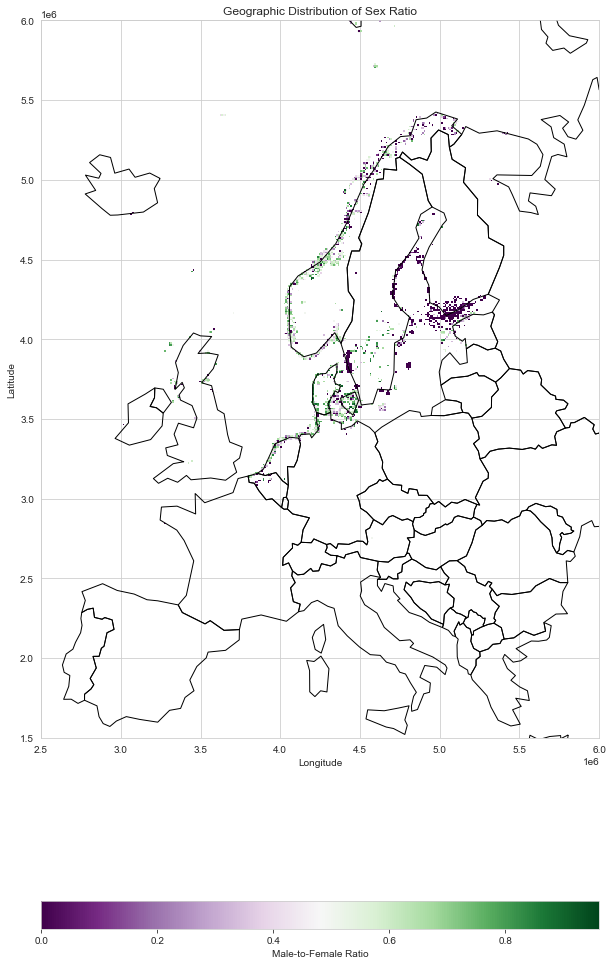

In [98]:
# Example bounds (you'll replace these with your desired bounds)
min_longitude, max_longitude = 2500000, 6000000  # Adjust these values to your desired longitude bounds
min_latitude, max_latitude = 1500000, 6000000    # Adjust these values to your desired latitude bounds



fig, ax = plt.subplots(1, 1, figsize=(10, 20))

# Plot using the 'sex_ratio' column to color the points
filtered_gdf.plot(edgecolor='none', column='male_to_female_ratio', ax=ax, legend=True, 
         legend_kwds={'label': "Male-to-Female Ratio", 'orientation': "horizontal"},
         cmap='PRGn', markersize=50, alpha=1)  # Adjust 'markersize' and 'alpha' as needed
europe.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# Set the x and y limits to your desired bounds
ax.set_xlim(min_longitude, max_longitude)
ax.set_ylim(min_latitude, max_latitude)

plt.title('Geographic Distribution of Sex Ratio')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot as a JPG file with 600 DPI (dots per inch), which is equivalent to PPI (pixels per inch)
plt.savefig('duckmap.jpg', dpi=600, format='jpg')

plt.show()